<h1>The searchlight method for decoding</h1>

<i>Antoine SIMOULIN *</i>

* <a href="https://nilearn.github.io/decoding/searchlight.html">seachlight method : Nilearn documentation</a>
* <a href="http://nilearn.github.io/auto_examples/02_decoding/plot_haxby_searchlight.html#sphx-glr-auto-examples-02-decoding-plot-haxby-searchlight-py">seachlight example in Nilearn</a>
* <a href="http://nilearn.github.io/auto_examples/02_decoding/plot_haxby_anova_svm.html#sphx-glr-auto-examples-02-decoding-plot-haxby-anova-svm-py">Decoding with ANOVA + SVM</a>

<i>*antoine.simoulin@gmail.com</i>


<h2>Searchlight analysis of face vs house recognition</h2>


Searchlight analysis requires fitting a classifier a large amount of
times. As a result, it is an intrinsically slow method. In order to speed
up computing, in this example, Searchlight is run only on one slice on
the fMRI (see the generated figures).




<h2>Load Haxby dataset</h2>


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from nilearn import datasets
from nilearn.image import new_img_like, load_img

# We fetch 2nd subject from haxby datasets (which is default)
haxby_dataset = datasets.fetch_haxby()

# print basic information on the dataset
print('Anatomical nifti image (3D) is located at: %s' % haxby_dataset.mask)
print('Functional nifti image (4D) is located at: %s' % haxby_dataset.func[0])

fmri_filename = haxby_dataset.func[0]
labels = np.recfromcsv(haxby_dataset.session_target[0], delimiter=" ")
y = labels['labels']
session = labels['chunks']

Anatomical nifti image (3D) is located at: /Users/Antoine/nilearn_data/haxby2001/mask.nii.gz
Functional nifti image (4D) is located at: /Users/Antoine/nilearn_data/haxby2001/subj2/bold.nii.gz


<h2>Restrict to faces and houses</h2>



In [2]:
from nilearn.image import index_img
condition_mask = np.logical_or(y == b'face', y == b'house')

fmri_img = index_img(fmri_filename, condition_mask)
y, session = y[condition_mask], session[condition_mask]

<h2>Prepare masks</h2>

- mask_img is the original mask
- process_mask_img is a subset of mask_img, it contains the voxels that
  should be processed (we only keep the slice z = 26 and the back of the
  brain to speed up computation)



In [3]:
mask_img = load_img(haxby_dataset.mask)

# .astype() makes a copy.
process_mask = mask_img.get_data().astype(np.int)
#picked_slice = 29
#process_mask[..., (picked_slice + 1):] = 0
#process_mask[..., :picked_slice] = 0
#process_mask[:, 30:] = 0
process_mask_img = new_img_like(mask_img, process_mask)

<h2>Searchlight computation</h2>



In [4]:
# Make processing parallel
# /!\ As each thread will print its progress, n_jobs > 1 could mess up the
#     information output.
n_jobs = 2

# Define the cross-validation scheme used for validation.
# Here we use a KFold cross-validation on the session, which corresponds to
# splitting the samples in 4 folds and make 4 runs using each fold as a test
# set once and the others as learning sets
from sklearn.cross_validation import KFold
cv = KFold(y.size, n_folds=4)

import nilearn.decoding
# The radius is the one of the Searchlight sphere that will scan the volume
searchlight = nilearn.decoding.SearchLight(
    mask_img,
    process_mask_img=process_mask_img,
    radius=5.6, n_jobs=n_jobs,
    verbose=0, cv=cv)
searchlight.fit(fmri_img, y)

/Users/Antoine/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


SearchLight(cv=sklearn.cross_validation.KFold(n=216, n_folds=4, shuffle=False, random_state=None),
      estimator='svc',
      mask_img=<nibabel.nifti1.Nifti1Image object at 0x105e67780>,
      n_jobs=2,
      process_mask_img=<nibabel.nifti1.Nifti1Image object at 0x1046b03c8>,
      radius=5.6, scoring=None, verbose=0)

<h2>F-scores computation</h2>



In [5]:
from nilearn.input_data import NiftiMasker

# For decoding, standardizing is often very important
nifti_masker = NiftiMasker(mask_img=mask_img, sessions=session,
                           standardize=True, memory='nilearn_cache',
                           memory_level=1)
fmri_masked = nifti_masker.fit_transform(fmri_img)

from sklearn.feature_selection import f_classif
f_values, p_values = f_classif(fmri_masked, y)
p_values = -np.log10(p_values)
p_values[p_values > 10] = 10
p_unmasked = nifti_masker.inverse_transform(p_values).get_data()

<h2>Visualization</h2>



/Users/Antoine/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


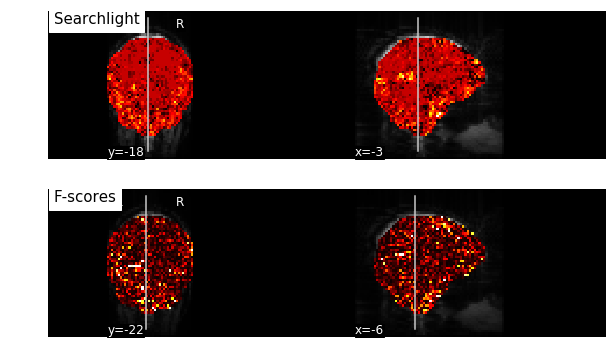

In [83]:
# Use the fmri mean image as a surrogate of anatomical data
from nilearn import image
mean_fmri = image.mean_img(fmri_img)

from nilearn.plotting import plot_stat_map, plot_img, show
searchlight_img = new_img_like(mean_fmri, searchlight.scores_)

# Because scores are not a zero-center test statistics, we cannot use
# plot_stat_map
f, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=[10,6])

plot_img(searchlight_img, bg_img=mean_fmri,
         title="Searchlight", display_mode="z", cut_coords=[-20, -5, 5, 20],
         vmin=.42, cmap='hot', threshold=.2, black_bg=True,figure=f,axes=ax1)

# F_score results
p_ma = np.ma.array(p_unmasked, mask=np.logical_not(process_mask))
f_score_img = new_img_like(mean_fmri, p_ma)
plot_stat_map(f_score_img, mean_fmri,
              title="F-scores", display_mode="z",
              cut_coords=[-20, -5, 5, 20],
              colorbar=False,figure=f,axes=ax2)

show()

/Users/Antoine/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


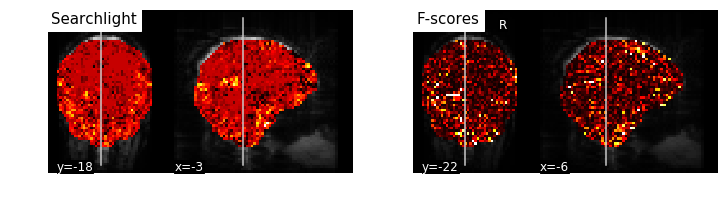

In [87]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=[12,3])

plot_img(searchlight_img, bg_img=mean_fmri,
         title="Searchlight", display_mode="yx",
         vmin=.42, cmap='hot', threshold=.2, black_bg=True,figure=f,axes=ax1)

# F_score results
p_ma = np.ma.array(p_unmasked, mask=np.logical_not(process_mask))
f_score_img = new_img_like(mean_fmri, p_ma)
plot_stat_map(f_score_img, mean_fmri,
              title="F-scores", display_mode="yx",
              colorbar=False,figure=f,axes=ax2)

show()

<h2> Decoding with ANOVA + SVM: face vs house in the Haxby dataset </h2>

This example does a simple but efficient decoding on the Haxby dataset:
using a feature selection, followed by an SVM.




In [32]:
import numpy as np
labels = np.recfromcsv(haxby_dataset.session_target[0], delimiter=" ")
y = labels['labels']
session = labels['chunks']

# Restrict to faces and houses
condition_mask = np.logical_or(y == b'face', y == b'house')
y = y[condition_mask]

# We have 2 conditions
n_conditions = np.size(np.unique(y))

In [33]:
# Prepare the fMRI data

from nilearn.input_data import NiftiMasker

mask_filename = haxby_dataset.mask
# For decoding, standardizing is often very important
nifti_masker = NiftiMasker(mask_img=mask_filename, sessions=session,
                           smoothing_fwhm=4, standardize=True,
                           memory="nilearn_cache", memory_level=1)
func_filename = haxby_dataset.func[0]
X = nifti_masker.fit_transform(func_filename)
# Apply our condition_mask
X = X[condition_mask]
session = session[condition_mask]

In [34]:
# Build the decoder

# Define the prediction function to be used.
# Here we use a Support Vector Classification, with a linear kernel
from sklearn.svm import SVC
svc = SVC(kernel='linear')

# Define the dimension reduction to be used.
# Here we use a classical univariate feature selection based on F-test,
# namely Anova. We set the number of features to be selected to 500
from sklearn.feature_selection import SelectKBest, f_classif
feature_selection = SelectKBest(f_classif, k=500)

# We have our classifier (SVC), our feature selection (SelectKBest), and now,
# we can plug them together in a *pipeline* that performs the two operations
# successively:
from sklearn.pipeline import Pipeline
anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])

In [43]:
# Fit the decoder and predict

anova_svc.fit(X, y)
y_pred = anova_svc.predict(X)

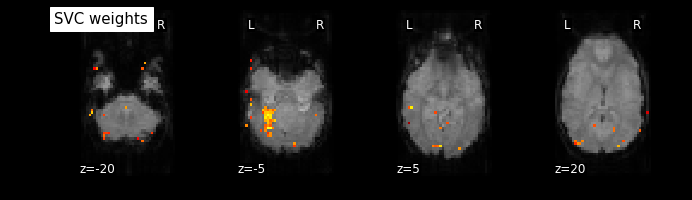

In [62]:
# Visualize the results

# Look at the SVC's discriminating weights
coef = svc.coef_
# reverse feature selection
coef = feature_selection.inverse_transform(coef)
# reverse masking
weight_img = nifti_masker.inverse_transform(coef)


# Create the figure
from nilearn import image
from nilearn.plotting import plot_stat_map, show

# Plot the mean image because we have no anatomic data
mean_img = image.mean_img(func_filename)

plot_stat_map(weight_img, mean_img, title='SVC weights', display_mode="z",
              cut_coords=[-20, -5, 5, 20],
              cmap='hot', black_bg=True,
              colorbar=False)

# Saving the results as a Nifti file may also be important
weight_img.to_filename('haxby_face_vs_house.nii')
show()

/Users/Antoine/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


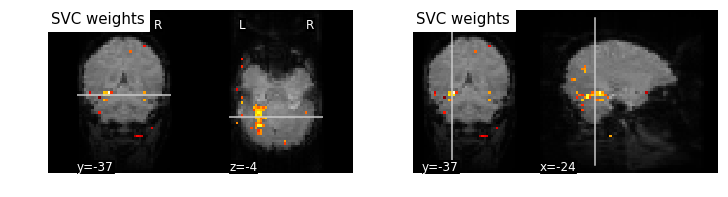

In [90]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=[12,3])


plot_stat_map(weight_img, mean_img, title='SVC weights', display_mode="yz",
              cmap='hot', black_bg=True,
              colorbar=False,
              figure=f,axes=ax1)


plot_stat_map(weight_img, mean_img, title='SVC weights', display_mode="yx",
              cmap='hot', black_bg=True,
              colorbar=False,
              figure=f,axes=ax2)

show()

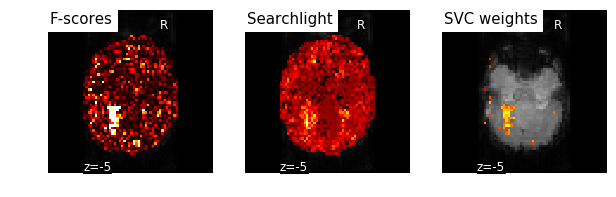

In [79]:
cut = [-5]
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=[10,3])

# F_score results
p_ma = np.ma.array(p_unmasked, mask=np.logical_not(process_mask))
f_score_img = new_img_like(mean_fmri, p_ma)
plot_stat_map(f_score_img, mean_fmri,
              title="F-scores", display_mode="z",
              cut_coords=cut,
              colorbar=False,figure=f,axes=ax1)

plot_img(searchlight_img, bg_img=mean_fmri,
     title="Searchlight", display_mode="z", cut_coords=cut,
     vmin=.42, cmap='hot', threshold=.2, black_bg=True,figure=f,axes=ax2)

plot_stat_map(weight_img, mean_img, title='SVC weights', display_mode="z",
              cut_coords=cut,
              cmap='hot', black_bg=True,
              colorbar=False,figure=f,axes=ax3)

show()

In [45]:
# Obtain prediction scores via cross validation

from sklearn.cross_validation import LeaveOneLabelOut

# Define the cross-validation scheme used for validation.
# Here we use a LeaveOneLabelOut cross-validation on the session label
# divided by 2, which corresponds to a leave-two-session-out
cv = LeaveOneLabelOut(session // 2)

# Compute the prediction accuracy for the different folds (i.e. session)
cv_scores = []
for train, test in cv:
    anova_svc.fit(X[train], y[train])
    y_pred = anova_svc.predict(X[test])
    cv_scores.append(np.sum(y_pred == y[test]) / float(np.size(y[test])))

# Return the corresponding mean prediction accuracy
classification_accuracy = np.mean(cv_scores)

# Print the results
print("Classification accuracy: %.4f / Chance level: %f" %
      (classification_accuracy, 1. / n_conditions))
# Classification accuracy: 0.9861 / Chance level: 0.5000

Classification accuracy: 0.9815 / Chance level: 0.500000
